# Visualization

## Calculate metrics

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from sentinel import SentinelDataset
from unet import Sentinel12UNetTopo
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import cv2

from torchmetrics.image import StructuralSimilarityIndexMeasure
from torchmetrics.image import PeakSignalNoiseRatio
from torchmetrics.image import SpectralAngleMapper
from torchmetrics.image import UniversalImageQualityIndex
from torchmetrics.regression import MeanSquaredError
from torchmetrics.image import ErrorRelativeGlobalDimensionlessSynthesis

def get_metrics(filename , x, y):
    mse = MeanSquaredError().to(device) ## lower u¡is better 
    ssim = StructuralSimilarityIndexMeasure().to(device) # ideal is 1
    psnr = PeakSignalNoiseRatio().to(device)  # higher is better
    sam =SpectralAngleMapper().to(device) ## 0 
    uiq = UniversalImageQualityIndex().to(device) # close to 1
    ergas = ErrorRelativeGlobalDimensionlessSynthesis().to(device)
    return  [filename, float(mse(x,y).cpu().numpy()), float(ssim(x,y).cpu().numpy()),float(psnr(x,y).cpu().numpy()), float(sam(x,y).cpu().numpy()) ,float(uiq(x,y).cpu().numpy()), float(ergas(x,y).cpu().numpy())]
    

def cloud_percentage(tensor):
    total_elements = tensor.numel()
    
    # Calculate the number of zero elements in the tensor
    zero_elements = np.count_nonzero(tensor == 0)

    # Calculate the percentage of zero values
    percentage_cloud = ((total_elements - zero_elements) / total_elements) * 100

    return percentage_cloud
    
def to_tensor(x, **kwargs):
    return torch.from_numpy(x.transpose(2, 0, 1).astype('float32'))



class RandomCrop(object):
    def __init__(self, crop_size, p=0.5):
        self.crop_size = crop_size
        self.p = p

    def __call__(self, **data):
        image = data['image']
        mask = data['mask']

        if np.random.rand() <= self.p:
            h, w = image.shape[:2]
            new_h, new_w = self.crop_size
            top = np.random.randint(0, h - new_h)
            left = np.random.randint(0, w - new_w)

            image = image[top: top + new_h, left: left + new_w]
            mask = mask[top: top + new_h, left: left + new_w]

        return {'image': image, 'mask': mask}
    

class MyStructureMain:
    def __init__(self,lr, resume, data_dir, csv_file, path_to_checkpoint, path_to_save_models,epochs, batch_size, num_workers):
        
        self.lr = lr
        self.resume = resume
        self.data_dir = data_dir
        self.csv_file = csv_file
        self.path_to_checkpoint = path_to_checkpoint
        self.path_to_save_models = path_to_save_models
        self.epochs = epochs
        self.batch_size = batch_size
        self.num_workers = num_workers



# Create an instance of the "structure"
opt = MyStructureMain(0.0001, False, '/mnt/nvme1', '/data/mboumahdi/codes/full_dataset_1.0_256_256.csv', 
                      '/mnt/nvme1/models_decloud/','/mnt/nvme1/models_decloud/', 150, 1, 1)

metric = pd.DataFrame(columns=['filename', 'mse', 'ssim', 'psnr', 'sam', 'uiq', 'ergas', 'cloud'])
# Start with main code
if __name__ == '__main__':
    # argparse for additional flags for experiment
    model = Sentinel12UNetTopo()
    loaded_state_dict = torch.load('/mnt/nvme1/models_decloud/Sentinel12UNetTopo_Full_No_EarlyStop_Batch_8_150_2023-11-08.ckpt')
    model.load_state_dict(loaded_state_dict['model'])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    df = pd.read_csv(opt.csv_file)
    df_test = df[df['set'] == 'test']
    
    #df_test = df_test[len(df_test)-6:len(df_test)-1]
    
    df_test = df_test.reset_index(drop=True)
    
    for l in tqdm(range(0, len(df_test))):
        line = df_test[l:l+1]
        line = line.reset_index(drop=True)
    
        dataset_test  = SentinelDataset(opt.data_dir, line['filename'], subset = 'test')  # You can adjust subset


        dataloader_test = DataLoader(dataset_test, batch_size=opt.batch_size, shuffle=False,
                                    num_workers=opt.num_workers, pin_memory=True)
        
        pbar = enumerate(dataloader_test)
    
        for i, data in pbar:
                            # data preparation
            s2_10_input = data['s2_10m_input'].to(device)
            s2_20_input = data['s2_20m_input'].to(device)
            s1_10 = data['s1_10m'].to(device)
            aspect_20 = data['aspect'].to(device)
            slope_20 = data['slope'].to(device)
            hillshade_20 = data['hillshade'].to(device)
            dem_20 = data['dem'].to(device)
            mask = data['cloud_mask']
            s2_10_output = data['s2_10m_output'].to(device)
            s2_20_output = data['s2_20m_output'].to(device)

            y = torch.cat([s2_10_output, s2_20_output], 1)

            y_hat = model(s2_10_input, s2_20_input, s1_10, aspect_20, slope_20, hillshade_20, dem_20)
            y_hat = y_hat.detach()
            
            ## Calculate the metrics
            metric.loc[len(metric)] = get_metrics(line['filename'].item(), y, y_hat) + [cloud_percentage(mask)]
            '''

                            #num_figures = np.min((10, y_hat.shape[0]))
            num_figures = y_hat.shape[0]
            fig, axes = plt.subplots(nrows=num_figures, ncols=3, figsize=(12, int(3 * num_figures)), squeeze=False)
            for idx in range(num_figures):
                img_1 = np.rollaxis(np.squeeze(s2_10_input[idx][[2, 1, 0], :, :].cpu().numpy()), 0, 3)
                axes[idx][0].imshow(np.clip(img_1, 0.0, 1.0))
                axes[idx][0].set_title('S2 Cloudy '+ line['filename'].astype(str).item())
                axes[idx][0].set_axis_off()

                img_2 = np.rollaxis(np.squeeze(s2_10_output[idx][[2, 1, 0], :, :].cpu().numpy()), 0, 3)
                axes[idx][1].imshow(np.clip(img_2, 0.0, 1.0))
                axes[idx][1].set_title('S2 Clear '+line['filename'].astype(str).item())
                axes[idx][1].set_axis_off()

                img_pred = np.rollaxis(np.squeeze(y_hat[idx][[2, 1, 0], :, :].cpu().numpy()), 0, 3)
                axes[idx][2].imshow(np.clip(img_pred, 0.0, 1.0))
                axes[idx][2].set_title('S2 Predicted '+line['filename'].astype(str).item())
                axes[idx][2].set_axis_off()
            plt.tight_layout()
            plt.show()

            plt.close(fig)
            '''
#metric     
metric.to_csv('metrics_full_test_dataset.csv', index=False)
    

  0%|          | 0/3343 [00:00<?, ?it/s]/home/mboumahdi/anaconda3/envs/decloud/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:42: UserWarning: Metric `SpectralAngleMapper` will save all targets and predictions in the buffer. For large datasets, this may lead to a large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/mboumahdi/anaconda3/envs/decloud/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:42: UserWarning: Metric `UniversalImageQualityIndex` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028
  0%|          | 1/3343 [00:08<8:14:28,  8.88s/it]/home/mboumahdi/anaconda3/envs/decloud/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:42: UserWarning: Metric `SpectralAngleMapper` will save all targets and predictions in the buffer. For large datasets, this may lead to a large memory footprint.
  warnings.warn(*args, **kw

## Visualization

  0%|          | 0/1 [00:00<?, ?it/s]

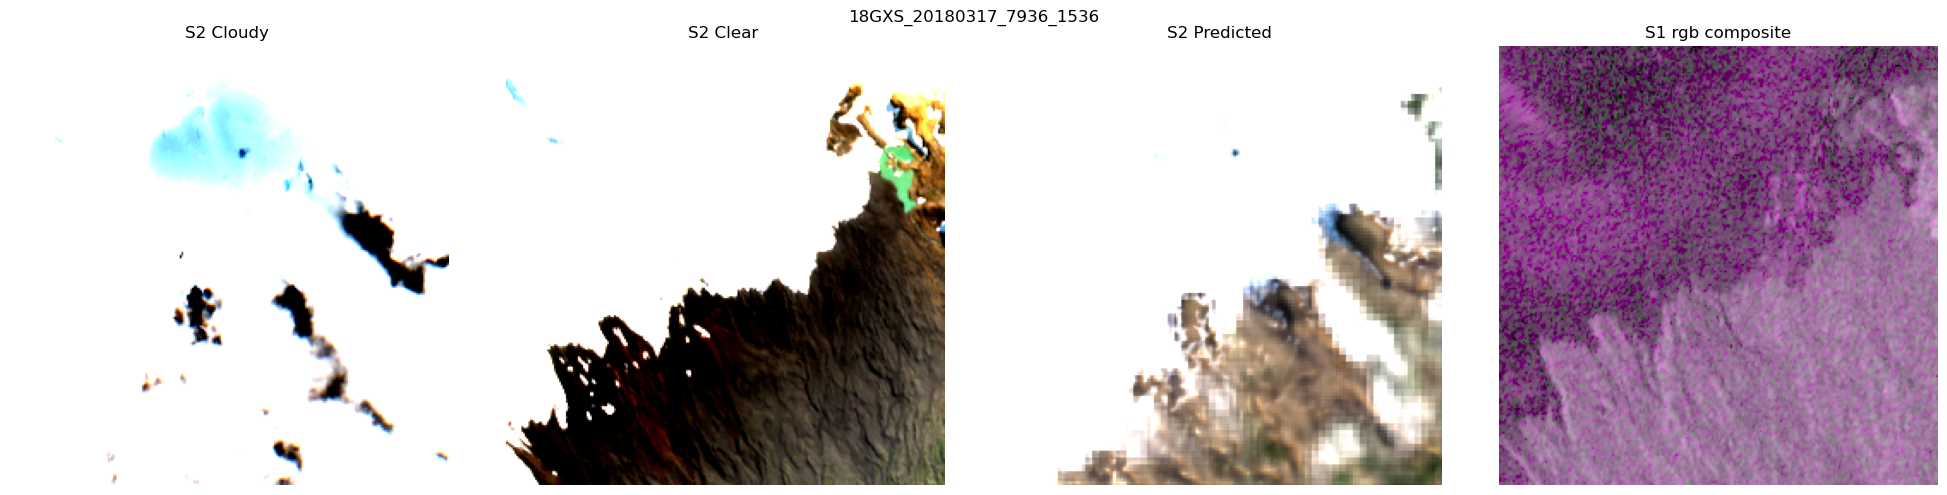

100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from sentinel import SentinelDataset
from unet import Sentinel12UNetTopo
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import cv2

from torchmetrics.image import StructuralSimilarityIndexMeasure
from torchmetrics.image import PeakSignalNoiseRatio
from torchmetrics.image import SpectralAngleMapper
from torchmetrics.image import UniversalImageQualityIndex
from torchmetrics.regression import MeanSquaredError

    
def to_tensor(x, **kwargs):
    return torch.from_numpy(x.transpose(2, 0, 1).astype('float32'))



class RandomCrop(object):
    def __init__(self, crop_size, p=0.5):
        self.crop_size = crop_size
        self.p = p

    def __call__(self, **data):
        image = data['image']
        mask = data['mask']

        if np.random.rand() <= self.p:
            h, w = image.shape[:2]
            new_h, new_w = self.crop_size
            top = np.random.randint(0, h - new_h)
            left = np.random.randint(0, w - new_w)

            image = image[top: top + new_h, left: left + new_w]
            mask = mask[top: top + new_h, left: left + new_w]

        return {'image': image, 'mask': mask}
    

class MyStructureMain:
    def __init__(self,lr, resume, data_dir, csv_file, path_to_checkpoint, path_to_save_models,epochs, batch_size, num_workers):
        
        self.lr = lr
        self.resume = resume
        self.data_dir = data_dir
        self.csv_file = csv_file
        self.path_to_checkpoint = path_to_checkpoint
        self.path_to_save_models = path_to_save_models
        self.epochs = epochs
        self.batch_size = batch_size
        self.num_workers = num_workers



# Create an instance of the "structure"
#opt = MyStructureMain(0.0001, False, '/mnt/nvme1/dataset_S2A', '/data/mboumahdi/codes/Tiles_dataset_1.0_256_256.csv', 
#                      '/mnt/nvme1/models_decloud/','/mnt/nvme1/models_decloud/', 150, 1, 1)

opt = MyStructureMain(0.0001, False, '/mnt/nvme1/dataset_S2B', '/data/mboumahdi/codes/Tiles_dataset_S2B_1.0_256_256.csv', 
                      '/mnt/nvme1/models_decloud/','/mnt/nvme1/models_decloud/', 150, 1, 1)
# Start with main code
if __name__ == '__main__':
    # argparse for additional flags for experiment
    model = Sentinel12UNetTopo()
    loaded_state_dict = torch.load('/mnt/nvme1/models_decloud/Sentinel12UNetTopo_Tiles_S2B_No_EarlyStop_Batch_8_150_2023-10-01.ckpt')
    model.load_state_dict(loaded_state_dict['model'])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    df = pd.read_csv(opt.csv_file)
    df_test = df[df['set'] == 'test']
    
    patch_number = 21
    patch_number_max = 30
    #df_test = df_test[patch_number:patch_number_max]
    df_test = df_test[patch_number-1:patch_number]
    df_test = df_test.reset_index(drop=True)
    
    for l in tqdm(range(0, len(df_test))):
        line = df_test[l:l+1]
        line = line.reset_index(drop=True)
    
        dataset_test  = SentinelDataset(opt.data_dir, line['filename'], subset = 'test')  # You can adjust subset


        dataloader_test = DataLoader(dataset_test, batch_size=opt.batch_size, shuffle=False,
                                    num_workers=opt.num_workers, pin_memory=True)
        
        pbar = enumerate(dataloader_test)
    
        for i, data in pbar:
                            # data preparation
            s2_10_input = data['s2_10m_input'].to(device)
            s2_20_input = data['s2_20m_input'].to(device)
            cloud = data['cloud_mask'].to(device)
            s1_10 = data['s1_10m'].to(device)
            aspect_20 = data['aspect'].to(device)
            slope_20 = data['slope'].to(device)
            hillshade_20 = data['hillshade'].to(device)
            dem_20 = data['dem'].to(device)

            s2_10_output = data['s2_10m_output'].to(device)
            s2_20_output = data['s2_20m_output'].to(device)

            y = torch.cat([s2_10_output, s2_20_output], 1)
            s1_10_duplicate =torch.cat([s1_10,s1_10],1)

            y_hat = model(s2_10_input, s2_20_input, s1_10, aspect_20, slope_20, hillshade_20, dem_20)
            y_hat = y_hat.detach()
            

                            #num_figures = np.min((10, y_hat.shape[0]))
            num_figures = y_hat.shape[0]
            fig, axes = plt.subplots(nrows=num_figures, ncols=4, figsize=(20, int(5 * num_figures)), squeeze=False)
            fig.suptitle(line['filename'].astype(str).item())
            for idx in range(num_figures):
                
                img_1 = np.rollaxis(np.squeeze(10*s2_10_input[idx][[2, 1, 0], :, :].cpu().numpy()), 0, 3)
                axes[idx][0].imshow(np.clip(img_1, 0.0, 1.0))
                axes[idx][0].set_title('S2 Cloudy ')
                axes[idx][0].set_axis_off()

                img_2 = np.rollaxis(np.squeeze(10*s2_10_output[idx][[2, 1, 0], :, :].cpu().numpy()), 0, 3)
                axes[idx][1].imshow(np.clip(img_2, 0.0, 1.0))
                axes[idx][1].set_title('S2 Clear ')
                axes[idx][1].set_axis_off()

                img_pred = np.rollaxis(np.squeeze(10*y_hat[idx][[2, 1, 0], :, :].cpu().numpy()), 0, 3)
                axes[idx][2].imshow(np.clip(img_pred, 0.0, 1.0))
                axes[idx][2].set_title('S2 Predicted ')
                axes[idx][2].set_axis_off()
                
                #img_3 = np.rollaxis(np.squeeze(cloud[idx][:, :, :].cpu().numpy()), 0, 3)
                #img_3 = cloud[idx][0, :, :].cpu().numpy()
                #im = axes[idx][3].imshow(img_3)
                #axes[idx][3].set_title('Cloud Mask'+line['filename'].astype(str).item())
                #axes[idx][3].set_axis_off()
                #cbar = plt.colorbar(im, ax=axes[idx][3])  # Add colorbar to the third subplot
                #cbar.set_label('Colorbar Label')  # Set a label for the colorbar
                
                
                img_4 =  np.rollaxis(np.squeeze(s1_10_duplicate[idx][[2, 1, 0], :, :].cpu().numpy()), 0, 3)
                axes[idx][3].imshow(img_4)
                axes[idx][3].set_title('S1 rgb composite')
                axes[idx][3].set_axis_off()
                

            plt.tight_layout()
            plt.show()

            plt.close(fig)
            
torch.cuda.empty_cache()

# Plot 20 m composition

  0%|          | 0/1 [00:00<?, ?it/s]

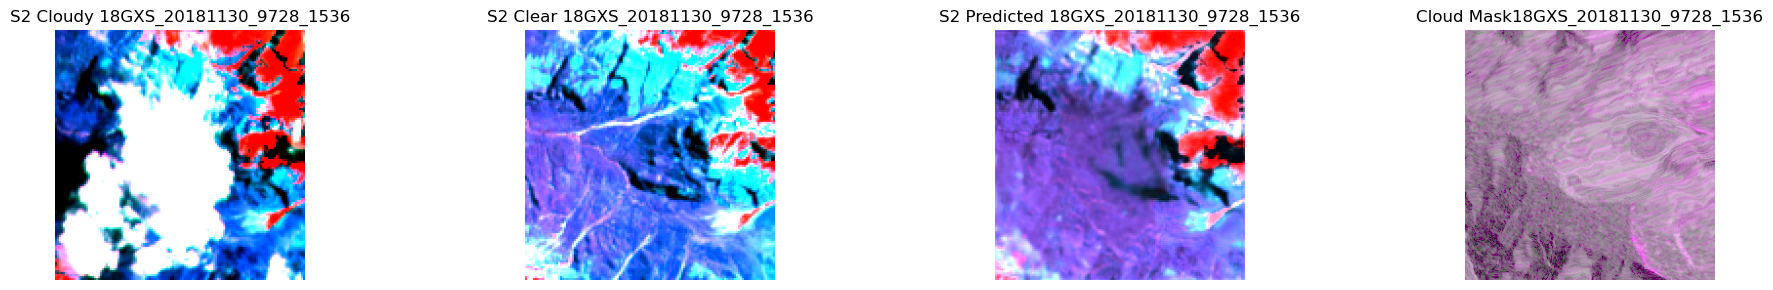

100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from sentinel import SentinelDataset
from unet import Sentinel12UNetTopo
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import cv2

from torchmetrics.image import StructuralSimilarityIndexMeasure
from torchmetrics.image import PeakSignalNoiseRatio
from torchmetrics.image import SpectralAngleMapper
from torchmetrics.image import UniversalImageQualityIndex
from torchmetrics.regression import MeanSquaredError

    
def to_tensor(x, **kwargs):
    return torch.from_numpy(x.transpose(2, 0, 1).astype('float32'))



class RandomCrop(object):
    def __init__(self, crop_size, p=0.5):
        self.crop_size = crop_size
        self.p = p

    def __call__(self, **data):
        image = data['image']
        mask = data['mask']

        if np.random.rand() <= self.p:
            h, w = image.shape[:2]
            new_h, new_w = self.crop_size
            top = np.random.randint(0, h - new_h)
            left = np.random.randint(0, w - new_w)

            image = image[top: top + new_h, left: left + new_w]
            mask = mask[top: top + new_h, left: left + new_w]

        return {'image': image, 'mask': mask}
    

class MyStructureMain:
    def __init__(self,lr, resume, data_dir, csv_file, path_to_checkpoint, path_to_save_models,epochs, batch_size, num_workers):
        
        self.lr = lr
        self.resume = resume
        self.data_dir = data_dir
        self.csv_file = csv_file
        self.path_to_checkpoint = path_to_checkpoint
        self.path_to_save_models = path_to_save_models
        self.epochs = epochs
        self.batch_size = batch_size
        self.num_workers = num_workers



# Create an instance of the "structure"
opt = MyStructureMain(0.0001, False, '/mnt/nvme1/dataset_S2A', '/data/mboumahdi/codes/Tiles_dataset_1.0_256_256.csv', 
                      '/mnt/nvme1/models_decloud/','/mnt/nvme1/models_decloud/', 150, 1, 1)

# Start with main code
if __name__ == '__main__':
    # argparse for additional flags for experiment
    model = Sentinel12UNetTopo()
    loaded_state_dict = torch.load('/mnt/nvme1/models_decloud/Sentinel12UNetTopo_Tiles_T18_No_EarlyStop_Batch_8_150_2023-09-11.ckpt')
    model.load_state_dict(loaded_state_dict['model'])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    df = pd.read_csv(opt.csv_file)
    df_test = df[df['set'] == 'test']
    
    patch_number = 30
    patch_number_max = 30
    #df_test = df_test[patch_number:patch_number_max]
    df_test = df_test[patch_number-1:patch_number]
    df_test = df_test.reset_index(drop=True)
    
    for l in tqdm(range(0, len(df_test))):
        line = df_test[l:l+1]
        line = line.reset_index(drop=True)
    
        dataset_test  = SentinelDataset(opt.data_dir, line['filename'], subset = 'test')  # You can adjust subset


        dataloader_test = DataLoader(dataset_test, batch_size=opt.batch_size, shuffle=False,
                                    num_workers=opt.num_workers, pin_memory=True)
        
        pbar = enumerate(dataloader_test)
    
        for i, data in pbar:
                            # data preparation
            s2_10_input = data['s2_10m_input'].to(device)
            s2_20_input = data['s2_20m_input'].to(device)
            cloud = data['cloud_mask'].to(device)
            s1_10 = data['s1_10m'].to(device)
            aspect_20 = data['aspect'].to(device)
            slope_20 = data['slope'].to(device)
            hillshade_20 = data['hillshade'].to(device)
            dem_20 = data['dem'].to(device)

            s2_10_output = data['s2_10m_output'].to(device)
            s2_20_output = data['s2_20m_output'].to(device)

            y = torch.cat([s2_10_output, s2_20_output], 1)
            s1_10_duplicate =torch.cat([s1_10,s1_10],1)

            y_hat = model(s2_10_input, s2_20_input, s1_10, aspect_20, slope_20, hillshade_20, dem_20)
            y_hat = y_hat.detach()
            

                            #num_figures = np.min((10, y_hat.shape[0]))
            num_figures = y_hat.shape[0]
            
            fig, axes = plt.subplots(nrows=num_figures, ncols=4, figsize=(20, int(3 * num_figures)), squeeze=False)
            for idx in range(num_figures):
                
                img_1 = np.rollaxis(np.squeeze(10*s2_20_input[idx][[2,1,0], :, :].cpu().numpy()), 0, 3)
                axes[idx][0].imshow(np.clip(img_1, 0.0, 1.0))
                axes[idx][0].set_title('S2 Cloudy '+ line['filename'].astype(str).item())
                axes[idx][0].set_axis_off()

                img_2 = np.rollaxis(np.squeeze(10*s2_20_output[idx][[2,1,0], :, :].cpu().numpy()), 0, 3)
                axes[idx][1].imshow(np.clip(img_2, 0.0, 1.0))
                axes[idx][1].set_title('S2 Clear '+line['filename'].astype(str).item())
                axes[idx][1].set_axis_off()

                img_pred = np.rollaxis(np.squeeze(10*y_hat[idx][[6,5,4], :, :].cpu().numpy()), 0, 3)
                axes[idx][2].imshow(np.clip(img_pred, 0.0, 1.0))
                axes[idx][2].set_title('S2 Predicted '+line['filename'].astype(str).item())
                axes[idx][2].set_axis_off()
                
                #img_3 = np.rollaxis(np.squeeze(cloud[idx][:, :, :].cpu().numpy()), 0, 3)
                #img_3 = cloud[idx][0, :, :].cpu().numpy()
                #im = axes[idx][3].imshow(img_3)
                #axes[idx][3].set_title('Cloud Mask'+line['filename'].astype(str).item())
                #axes[idx][3].set_axis_off()
                #cbar = plt.colorbar(im, ax=axes[idx][3])  # Add colorbar to the third subplot
                #cbar.set_label('Colorbar Label')  # Set a label for the colorbar
                
                
                img_4 =  np.rollaxis(np.squeeze(s1_10_duplicate[idx][[2, 1, 0], :, :].cpu().numpy()), 0, 3)
                axes[idx][3].imshow(img_4)
                axes[idx][3].set_title('Cloud Mask'+line['filename'].astype(str).item())
                axes[idx][3].set_axis_off()
                

            plt.tight_layout()
            plt.show()

            plt.close(fig)
            
torch.cuda.empty_cache()

## Calculate the dataset size

In [15]:
import pandas as pd
csv_file = '/data/mboumahdi/codes/full_dataset_1.0_256_256.csv'
df = pd.read_csv(csv_file)
df_test = df[df['set'] == 'validation']
len(df_test)

9580

## merge S2A and S2B

In [6]:
# Define a list of file paths for the CSV files you want to merge
csv_file_s2a = '/data/mboumahdi/codes/Tiles_dataset_1.0_256_256.csv'
csv_file_s2b = '/data/mboumahdi/codes/Tiles_dataset_S2B_1.0_256_256.csv'
full_csv = '/data/mboumahdi/codes/full_dataset_1.0_256_256.csv'
text_to_add_dict = {
    csv_file_s2a: 'dataset_S2A/',
    csv_file_s2b: 'dataset_S2B/'
    #full_csv: ' - Text for File 3'
}

# Create an empty DataFrame to store the merged data
merged_data = pd.DataFrame()

# Loop through the dictionary items and merge the CSV files
for file, text_to_add in text_to_add_dict.items():
    data = pd.read_csv(file)
    # Modify the column 'column_name_to_modify' by adding the text
    data['filename'] = text_to_add + data['filename'] 
    merged_data = pd.concat([merged_data, data], ignore_index=True)

# Save the merged data to a new CSV file
#merged_data.to_csv('merged_data.csv', index=False)

In [11]:
merged_data[len(merged_data)-10:len(merged_data)-1]

,filename,s2_input,s1_input,s2_target,cloud_s2_input,cloud_s2_target,x,y,date_s2,set
63999,dataset_S2B/19GBP_20221124_0_10496,/data/mboumahdi/S2/S2_PREPARE/S2B/T19GBP/SENTI...,/data/mboumahdi/S1/S1_PREPARE/T19GBP/s1a_19GBP...,/data/mboumahdi/S2/S2_PREPARE/S2B/T19GBP/SENTI...,0.22772216796875,0.0,0,10496,20221124,train
64000,dataset_S2B/19GBP_20221124_256_10496,/data/mboumahdi/S2/S2_PREPARE/S2B/T19GBP/SENTI...,/data/mboumahdi/S1/S1_PREPARE/T19GBP/s1a_19GBP...,/data/mboumahdi/S2/S2_PREPARE/S2B/T19GBP/SENTI...,0.0205535888671875,0.0,256,10496,20221124,test
64001,dataset_S2B/19GBP_20221124_768_10496,/data/mboumahdi/S2/S2_PREPARE/S2B/T19GBP/SENTI...,/data/mboumahdi/S1/S1_PREPARE/T19GBP/s1a_19GBP...,/data/mboumahdi/S2/S2_PREPARE/S2B/T19GBP/SENTI...,0.867431640625,0.0,768,10496,20221124,validation
64002,dataset_S2B/19GBP_20221124_1024_10496,/data/mboumahdi/S2/S2_PREPARE/S2B/T19GBP/SENTI...,/data/mboumahdi/S1/S1_PREPARE/T19GBP/s1a_19GBP...,/data/mboumahdi/S2/S2_PREPARE/S2B/T19GBP/SENTI...,0.78228759765625,0.0,1024,10496,20221124,train
64003,dataset_S2B/19GBP_20221124_1280_10496,/data/mboumahdi/S2/S2_PREPARE/S2B/T19GBP/SENTI...,/data/mboumahdi/S1/S1_PREPARE/T19GBP/s1a_19GBP...,/data/mboumahdi/S2/S2_PREPARE/S2B/T19GBP/SENTI...,0.155975341796875,0.0,1280,10496,20221124,train
64004,dataset_S2B/19GBP_20221124_2304_10496,/data/mboumahdi/S2/S2_PREPARE/S2B/T19GBP/SENTI...,/data/mboumahdi/S1/S1_PREPARE/T19GBP/s1a_19GBP...,/data/mboumahdi/S2/S2_PREPARE/S2B/T19GBP/SENTI...,0.0963134765625,0.0,2304,10496,20221124,train
64005,dataset_S2B/19GBP_20221124_2560_10496,/data/mboumahdi/S2/S2_PREPARE/S2B/T19GBP/SENTI...,/data/mboumahdi/S1/S1_PREPARE/T19GBP/s1a_19GBP...,/data/mboumahdi/S2/S2_PREPARE/S2B/T19GBP/SENTI...,0.011444091796875,0.0,2560,10496,20221124,train
64006,dataset_S2B/19GBP_20221124_2816_10496,/data/mboumahdi/S2/S2_PREPARE/S2B/T19GBP/SENTI...,/data/mboumahdi/S1/S1_PREPARE/T19GBP/s1a_19GBP...,/data/mboumahdi/S2/S2_PREPARE/S2B/T19GBP/SENTI...,0.0140380859375,0.0,2816,10496,20221124,train
64007,dataset_S2B/19GBP_20221124_3072_10496,/data/mboumahdi/S2/S2_PREPARE/S2B/T19GBP/SENTI...,/data/mboumahdi/S1/S1_PREPARE/T19GBP/s1a_19GBP...,/data/mboumahdi/S2/S2_PREPARE/S2B/T19GBP/SENTI...,0.183563232421875,0.0,3072,10496,20221124,train


In [12]:
merged_data.to_csv(full_csv, index=False)